## Semantic Segmentation for Grid Detection
Can we use a semseg model to find out where the futoshiki grid is an a given image?

In [67]:
from torchvision import models
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
import json
import segmentation_models_pytorch as smp
import torch
import pandas as pd
import numpy as np
import os
import cv2
import shutil

In [57]:
data_path = 'futopyshi/data/box_segmentation'

x_all_train_path = os.path.join(data_path, 'all_train')
x_train_path = os.path.join(data_path, 'train')
x_valid_path = os.path.join(data_path, 'validation')
x_test_path = os.path.join(data_path, 'test')

y_train_path = os.path.join(data_path, 'labels', 'train.csv')
y_valid_path = os.path.join(data_path, 'labels', 'valid.csv')
y_test_path = os.path.join(data_path, 'labels', 'test.csv')

In [44]:
labels_path = os.path.join(data_path, 'labels')
files = ['train.csv', 'train_2.csv', 'train_3.csv']

all_data = pd.concat([pd.read_csv(os.path.join(labels_path, f)) for f in files])

In [46]:
all_data.to_csv(os.path.join(labels_path, 'all_train.csv'), index=False)

In [48]:
all_train = pd.read_csv(os.path.join(labels_path, 'all_train.csv'))

In [55]:
# split image masks
train = all_train.sample(frac=0.75, replace=False, random_state=42)
validation = all_train[~all_train['filename'].isin(train['filename'])]

train.to_csv(y_train_path, index=False)
validation.to_csv(y_valid_path, index=False)

In [68]:
# split images
all_train_files = os.listdir(x_all_train_path)
train_files = [x for x in all_train_files if x in train['filename'].tolist()]
validation_files = [x for x in all_train_files if x in validation['filename'].tolist()]

_ = [shutil.copyfile(os.path.join(x_all_train_path, x), os.path.join(x_train_path, x)) for x in train_files]
_ = [shutil.copyfile(os.path.join(x_all_train_path, x), os.path.join(x_valid_path, x)) for x in validation_files]

In [69]:
import functools

def image_transpose_exif(im):
    """
    Apply Image.transpose to ensure 0th row of pixels is at the visual
    top of the image, and 0th column is the visual left-hand side.
    Return the original image if unable to determine the orientation.

    As per CIPA DC-008-2012, the orientation field contains an integer,
    1 through 8. Other values are reserved.

    Parameters
    ----------
    im: PIL.Image
       The image to be rotated.
    """

    exif_orientation_tag = 0x0112
    exif_transpose_sequences = [                   # Val  0th row  0th col
        [],                                        #  0    (reserved)
        [],                                        #  1   top      left
        [Image.FLIP_LEFT_RIGHT],                   #  2   top      right
        [Image.ROTATE_180],                        #  3   bottom   right
        [Image.FLIP_TOP_BOTTOM],                   #  4   bottom   left
        [Image.FLIP_LEFT_RIGHT, Image.ROTATE_90],  #  5   left     top
        [Image.ROTATE_270],                        #  6   right    top
        [Image.FLIP_TOP_BOTTOM, Image.ROTATE_90],  #  7   right    bottom
        [Image.ROTATE_90],                         #  8   left     bottom
    ]

    try:
        seq = exif_transpose_sequences[im._getexif()[exif_orientation_tag]]
    except Exception:
        return im
    else:
        return functools.reduce(type(im).transpose, seq, im)

In [70]:
class FutoshikiGridDataset(Dataset):
    """Futoshiki Grid dataset."""

    def __init__(self, csv_file, root_dir, resize=None, transform=None, augmentation=None, copies=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.grid_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.resize = resize
        self.transform = transform
        self.augmentation = augmentation
        self.copies = copies

    def __len__(self):
        if self.copies:
            return self.grid_frame.shape[0] * self.copies
        else:
            return self.grid_frame.shape[0] * self.copies

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        if self.copies:
            idx = idx % self.grid_frame.shape[0]

        img_name = os.path.join(self.root_dir,
                                self.grid_frame.iloc[idx, 0])
        image = cv2.imread(img_name)
        image = image_transpose_exif(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        shape = image.shape
                
        grid = self.grid_frame.loc[idx, 'region_shape_attributes']
        mask = get_mask(grid, shape[:2])
        mask = mask / 255
        # mask = np.stack(masks, axis=-1).astype('float')
        
        if self.resize is not None:
            image, mask = cv2.resize(image, (320, 480)), cv2.resize(mask, (320, 480))
            mask = mask.reshape((*mask.shape, 1))
            
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        if self.transform:
            sample = self.transform(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        return image, mask
    
def get_mask(row, shape):
    row = json.loads(row)
    coords = np.array([[x,y] for x, y in zip(row['all_points_x'], row['all_points_y'])])
    mask = np.zeros((*shape, 1))
    cv2.fillPoly(mask, [coords], 255)
    return mask

In [71]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(4, 3))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title(), color='white')
        plt.imshow(image)
    plt.show()

In [74]:
grid_dataset = FutoshikiGridDataset(y_train_path, x_train_path, 0.25, copies=2)
len(grid_dataset)

86

### Look at base images and masks

In [75]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

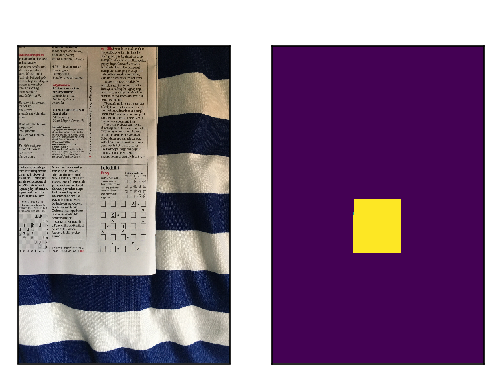

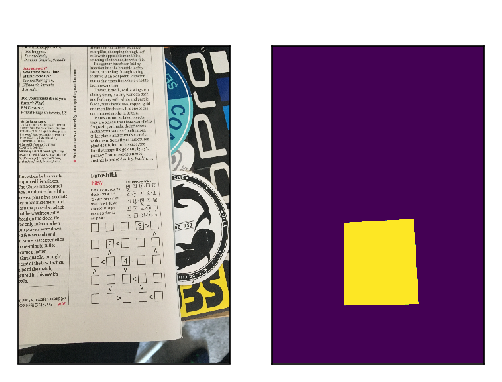

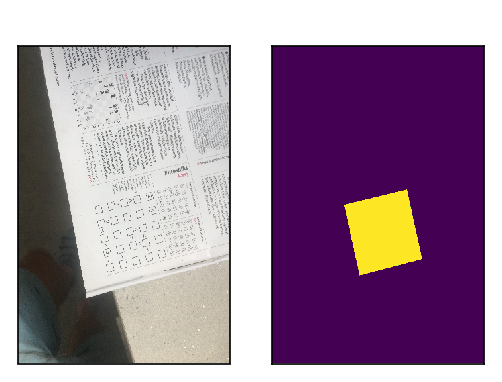

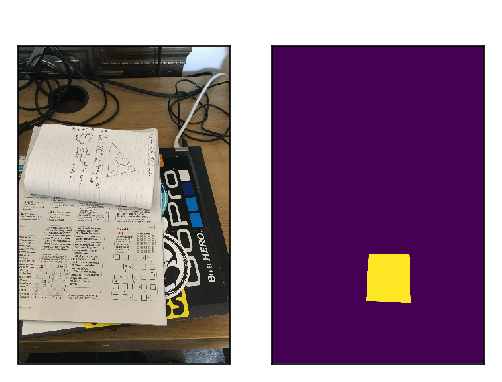

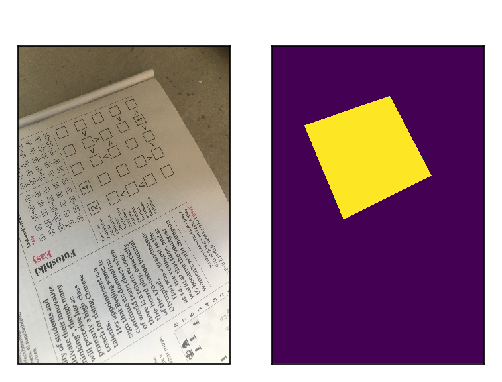

In [77]:
grid_dataset = FutoshikiGridDataset(y_train_path, x_train_path, 0.25)

for x in range(5):
    out = grid_dataset[x]
    visualize(
        image = out[0],
        mask = out[1].squeeze()
    )

### Data Augmentation

In [78]:
import albumentations as albu

In [79]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.2, rotate_limit=20, shift_limit=0.2, p=0.8, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.1),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

#         albu.OneOf(
#             [
#                 albu.IAASharpen(p=1),
#                 albu.Blur(blur_limit=3, p=1),
#                 albu.MotionBlur(blur_limit=3, p=1),
#             ],
#             p=0.9,
#         ),

#         albu.OneOf(
#             [
#                 albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(320, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

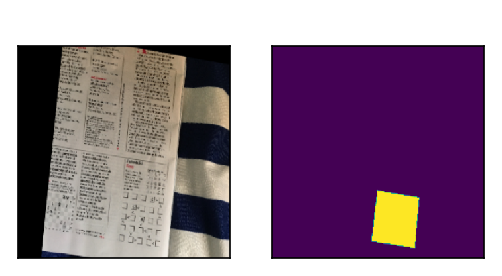

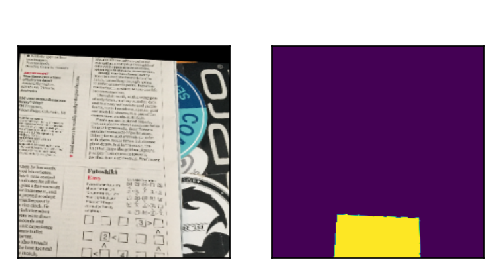

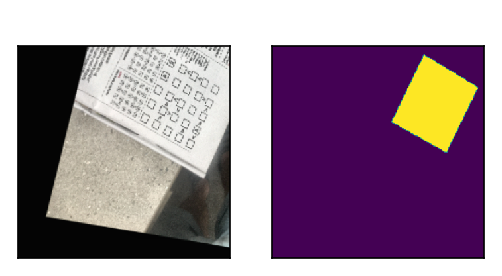

In [80]:
augmented_dataset = FutoshikiGridDataset(
    y_train_path, x_train_path, resize=0.25,
    augmentation=get_training_augmentation(), 
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[i]
    visualize(image=image, mask=mask.squeeze())

In [92]:
ENCODER = 'efficientnet-b3'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['grid']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = None

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [93]:
train_dataset = FutoshikiGridDataset(y_train_path, x_train_path, True, 
                                     get_preprocessing(preprocessing_fn), 
                                     get_training_augmentation(), copies=2)
print('Number of training samples:', len(grid_dataset))

valid_dataset = FutoshikiGridDataset(y_valid_path, x_valid_path, True, 
                                     get_preprocessing(preprocessing_fn), 
                                     get_validation_augmentation(), copies=1)

Number of training samples: 86


In [94]:
train_loader = DataLoader(grid_dataset, batch_size=8, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)

In [95]:
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# loss = smp.utils.losses.CrossEntropyLoss()
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0005),
])

In [96]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 40):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_2.pth')
        print('Model saved!')
        
    if i == 15:
        optimizer.param_groups[0]['lr'] = 5e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|█| 8/8 [00:22<00:00,  2.78s/it, dice_loss - 0.7914, iou_score - 0.1175] 
Model saved!

Epoch: 1
train:   9%| | 1/11 [00:33<05:31, 33.20s/it, dice_loss - 0.7047, iou_score - 0.1643]

In [96]:
torch.save(model, './best_model.pth')

In [23]:
model = torch.load('./best_model.pth')

### Visualise test predictions

In [24]:
test_dataset = FutoshikiGridDataset(
    y_test_path, x_test_path, resize=True,
    augmentation=get_validation_augmentation(), 
    transform=get_preprocessing(preprocessing_fn),
    copies=1
)

test_dataloader = DataLoader(test_dataset)

In [25]:
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|█| 14/14 [00:29<00:00,  2.12s/it, dice_loss - 0.4635, iou_score - 0.7023]


In [26]:
# test dataset without transformations for image visualization
test_dataset_vis = FutoshikiGridDataset(
    y_test_path, x_test_path, resize=True 
)

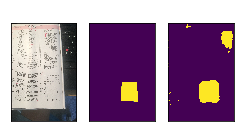

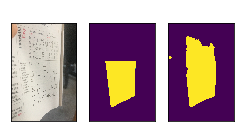

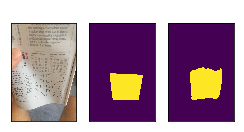

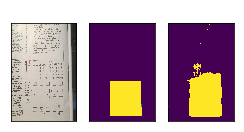

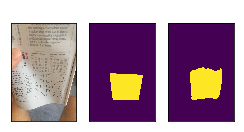

In [27]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).unsqueeze(0)
    pr_mask = model.predict(x_tensor)
    pr_mask = pr_mask.squeeze().numpy().round()
        
    visualize(
        image=image_vis, 
        actual=gt_mask, 
        predicted=pr_mask
    )

In [37]:
def mask_input(input_image, mask):
    mask = np.dstack([mask] * 3)
    mask = (mask == 1)
    #input_image = cv2.resize(input_image, (480, 320))
    return np.where(mask, input_image, 0)


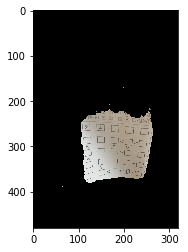

In [39]:
plt.imshow(mask_input(image_vis, pr_mask))

In [130]:
d_mask = np.dstack([pr_mask] * 3)
d_mask = (d_mask == 1)

In [135]:
image_vis_res = cv2.resize(image_vis, (480, 480))

In [142]:
plt.imshow(np.where(d_mask, image_vis_res, 0))

array([[[ 29,  28,  23],
        [ 54,  49,  47],
        [ 81,  73,  73],
        ...,
        [132,  92,  47],
        [131,  91,  45],
        [129,  91,  43]],

       [[ 32,  31,  27],
        [ 69,  66,  63],
        [104,  98,  94],
        ...,
        [130,  93,  48],
        [130,  92,  46],
        [128,  90,  43]],

       [[ 27,  23,  20],
        [ 67,  62,  58],
        [105,  99,  92],
        ...,
        [126,  88,  43],
        [127,  91,  45],
        [127,  93,  45]],

       ...,

       [[ 25,  25,  23],
        [ 25,  25,  23],
        [ 26,  26,  24],
        ...,
        [ 19,  27,  30],
        [ 21,  27,  31],
        [ 22,  27,  31]],

       [[ 28,  30,  27],
        [ 27,  28,  25],
        [ 26,  27,  23],
        ...,
        [ 18,  26,  29],
        [ 17,  25,  28],
        [ 17,  25,  28]],

       [[ 26,  27,  22],
        [ 25,  26,  21],
        [ 24,  26,  20],
        ...,
        [ 18,  26,  29],
        [ 18,  26,  29],
        [ 17,  25,  28]]

In [125]:
(pr_mask==1)[:, :, 0]

IndexError: too many indices for array

In [105]:
image.shape, pr_mask.shape

((3, 480, 480), (480, 480))

In [101]:
pr_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [100]:
image_vis.shape

(4032, 3024, 3)

In [98]:
plt.imshow(image_vis[:, pr_mask==1])

IndexError: boolean index did not match indexed array along dimension 1; dimension is 3024 but corresponding boolean dimension is 480

In [90]:
np.where()

array([[[ 0.2795616 ,  0.2795616 ,  0.26243687, ..., -0.3198048 ,
         -0.50817704, -0.4225533 ],
        [-0.59380084, -0.7136741 , -0.7479236 , ..., -0.45680282,
         -0.33692953, -0.5253018 ],
        [-0.8506721 , -0.9020464 , -0.9705454 , ..., -0.59380084,
         -0.59380084, -0.55955136],
        ...,
        [-1.9124069 , -1.9295317 , -1.9466563 , ..., -1.7754089 ,
         -1.8952821 , -1.9124069 ],
        [-2.0151553 , -1.8610326 , -1.9124069 , ..., -1.8781574 ,
         -1.9637811 , -1.9295317 ],
        [-1.8781574 , -1.9466563 , -1.9466563 , ..., -1.9124069 ,
         -1.8952821 , -1.8781574 ]],

       [[ 0.4327731 ,  0.5028011 ,  0.5553221 , ..., -0.12745099,
         -0.390056  , -0.320028  ],
        [-0.63515407, -0.61764705, -0.6526611 , ..., -0.320028  ,
         -0.214986  , -0.390056  ],
        [-0.7927171 , -0.8627451 , -0.9327731 , ..., -0.46008402,
         -0.46008402, -0.42507002],
        ...,
        [-1.7556022 , -1.8081232 , -1.8256303 , ..., -

In [89]:
pr_mask

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)